<img src="http://escolar.itam.mx/centro_tesis/img/logo-ITAM.png" style="width:250px">
# Machine Learning

## Cross-validation
Tarea 6 : Gustavo Augusto Mondragón Sánchez : 136894

### Introducción:
Cross-validation es una técnica de validación de modelo para evaluar cómo los resultados de un analisis estadístico pueden generalizarse a conjuntos de datos independientes. Es muy usado en modelos predictivos para estimar qué tan buen desempeño presenta en la práctica. 
La meta de cross-validation es proporcionar conjuntos de validación durante la fase de entrenamiento.

#### Cross-validation k iteraciones:
Los datos de entrenamiento se dividen en $k$ subconjuntos. Se hacen k iteraciones en las que se selecciona al subconjunto $k$ como conjunto de validación y los restantes se usan como conjunto de entrenamiento.
Finalmente se realiza la media aritmética de los resultados de cada iteración para obtener un sólo resultado.
<img src="https://upload.wikimedia.org/wikipedia/commons/f/f2/K-fold_cross_validation.jpg">
* Ventaja: Es preciso ya que evalúa el modelo varias veces con diferentes conjuntos de datos de entrenamiento y validación. 
* Desventaja: pesado computacionalmente.

[Wikipedia, Cross-validation](https://es.wikipedia.org/wiki/Validaci%C3%B3n_cruzada)

### Objetivos:
* Implementar el algoritmo de Cross-validation para encontrar el valor apropiado de lambda para el modelo de regresión lineal iterativa.

In [1]:
import pandas as pd
import numpy as np
import csv
import random as rnd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline

## Read file into dataframe

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/ClaseML-2017/MaterialyTareas/master/datos/regLinPoli2.csv',delimiter=',') # Leer el archivo

## Divide in train and test

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(df[df.columns[0:-1]],df[[df.columns[-1]]], train_size=0.75)

### I recommend that after manipulating data using pandas and before modelling to convert dataframes into arrays. This may avoid some headaches

In [5]:
X_train=np.asarray(X_train)
X_test=np.asarray(X_test)
Y_train=np.asarray(Y_train)
Y_test=np.asarray(Y_test)

## Procedure for data standardizing

In [6]:
# This procedure is useful for classroom examples. For a real implementation you have to have a separete method 
# for transforming the production data so you can transform it as you get it with the fitted scaler
## The procedure returns a standardized copy of the input data
def normalize(X_train,X_test,Y_train,Y_test,do=True):

    scale_X=preprocessing.StandardScaler()
    scale_y=preprocessing.StandardScaler()
    
    train_X=np.copy(X_train)
    train_y=np.copy(Y_train)
    test_X=np.copy(X_test)
    test_y=np.copy(Y_test)
    if do:
        scale_X.fit(train_X)
        scale_y.fit(train_y)
        train_X=scale_X.transform(train_X)
        train_y=scale_y.transform(train_y)
        test_X=scale_X.transform(test_X)
        test_y=scale_y.transform(test_y)
    return train_X,test_X, train_y, test_y

## Incremental regularized regression procedures

In [7]:
## Transfer function
def salida(w,X):
    return X.dot(w[1:]) +w[0]


In [8]:
## Training function
def entrena(X,y,w,la=0.0,eta=0.01):
    
    for i in range(len(X)):
        error=y[i]-salida(w,X[i])
        w[0]=w[0]+eta*(error)
        w[1:]=w[1:]+eta*(error*X[i])-la*w[1:]
    return w


## Error function

In [9]:
def calcError(X,y,w,w0):
    return np.mean((X.dot(w)+w0-y)**2)

## Use

In [10]:
train_X,test_X,train_y,test_y=normalize(X_train,X_test,Y_train,Y_test)

### Cross-validation

In [14]:
lai = 0.0
iteraciones = 100
errores = np.zeros((iteraciones,3))
for c in range(0,iteraciones):
    
    div = 5
    nt = len(X_train)
    lenDiv = nt/5
    err = np.zeros((div,2))
    for i in range(0, div):
        #Dividir los datos
        testi = range(i*lenDiv, (i+1)*lenDiv)
        traini = np.append(np.arange(0, i*lenDiv),np.arange((i+1)*lenDiv,nt))
        trainx,testx,trainy,testy=normalize(X_train[traini],X_train[testi],Y_train[traini],Y_train[testi])
        w=np.asarray([rnd.random() for k in range(1+len(trainx[0]))])
        for j in range(100):
            w=entrena(trainx,trainy,w,la=lai)

        eE = calcError(trainx,trainy.flatten(),w[1:],w[0])
        eV = calcError(testx,testy.flatten(),w[1:],w[0])
        err[i] = [eE,eV]

    #print "\n Error Cross-validation"
    eE = np.mean(err[:,0])
    eV = np.mean(err[:,1])
    #print "Error promedio de ENTRENAMIENTO:",eE
    #print "Error promedio de VALIDACIÓN:",eV
    eVN = np.mean(calcError(test_X,test_y.flatten(),w[1:],w[0]))
    #print "Error promedio SET DE VALIDACIÓN GENERAL:",eVN
    
    errores[c] = [eE,eV,eVN]
    lai = lai + .01


print "\n Error algoritmo usual"
w=np.asarray([rnd.random() for i in range(1+len(train_X[0]))])
for i in range(100):
    w=entrena(train_X,train_y,w,la=0.00)
    
print "Error ENTRENAMIENTO:",calcError(train_X,train_y.flatten(),w[1:],w[0])
print "Error VALIDACIÓN:",calcError(test_X,test_y.flatten(),w[1:],w[0])


 Error algoritmo usual
Error ENTRENAMIENTO: 0.546044481206
Error VALIDACIÓN: 0.533735734623


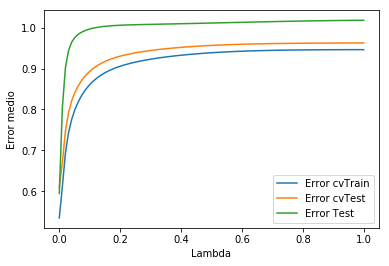

In [16]:
plt.plot(np.linspace(0.0,1.0, num=100), errores)
plt.xlabel("Lambda")
plt.ylabel("Error medio")
plt.legend(['Error cvTrain', 'Error cvTest', 'Error Test'])
plt.show()

### Conclusión:  
Se hace una evaluación de lambda desde 0.0 a 1.0 (como se aprecia el algoritmo sólo funciona correctamente con lambdas mayores o iguales a cero).
Se puede apreciar como el error a partir de cero aumenta hasta que llega a un estado asintótico próximo al error 1.
Con el algoritmo de Cross-validation se puede demostrar que lambda 0 es el mejor  valor de lambda para este modelo y estos datos. 